# Исследовательский анализ данных

**Цель исследования:** Используя данные сервиса Яндекс.Недвижимость, определить рыночную стоимость объектов недвижимости и типичные параметры квартир

**1.  Обзор данных**

Импортируем библиотеку pandas. Считаем данные из csv-файла в датафрейм и сохраняем в переменную data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from plotly import graph_objects as go

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

Выведим первые 20 строчек датафрейма data на экран.

In [3]:
data.head(10)
pd.set_option('display.max_columns', None)

Выведим основную информацию о датафрейме.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

Построим общую гистограмму для всех столбцов таблицы.

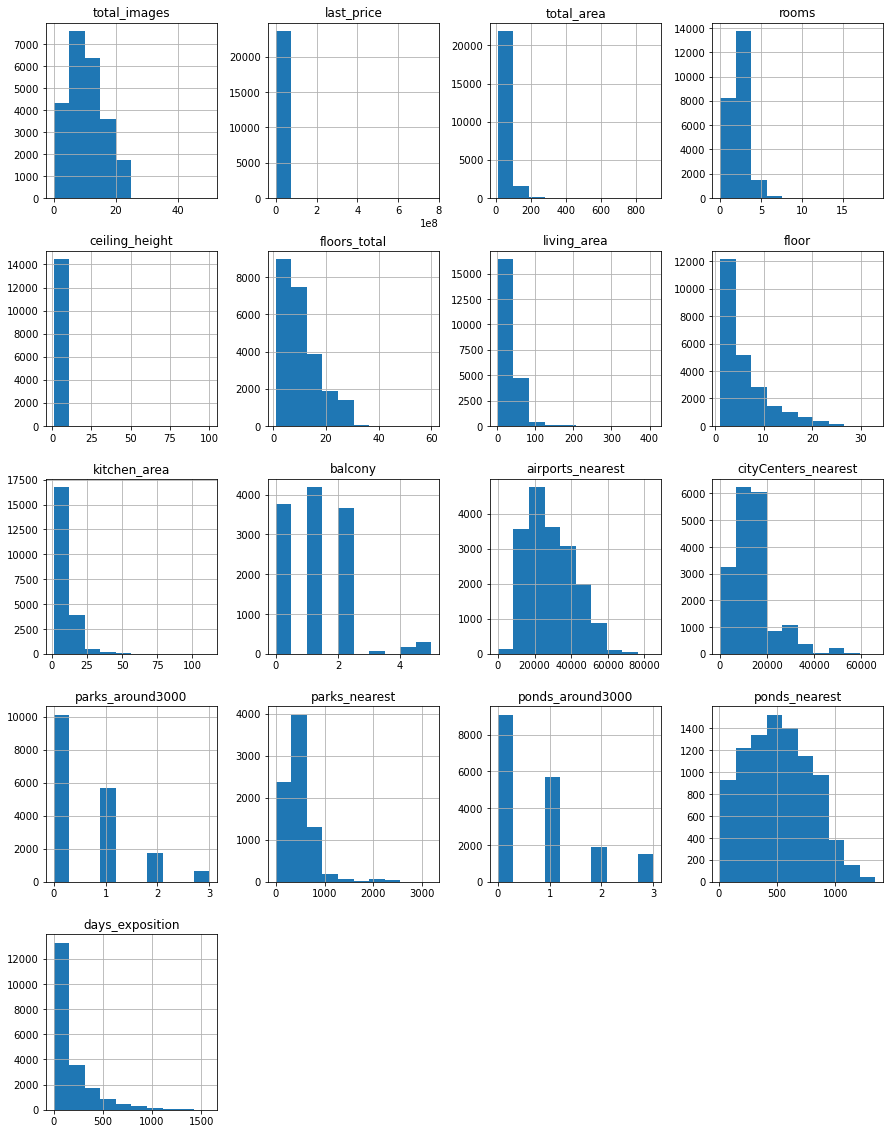

In [6]:
data.hist(figsize=(15, 20))
plt.show()

**2. Предобработка данных**

Выведим количество пропущенных значений для каждого столбца.

In [7]:
data.isna().sum()


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Среди пропущенных значений есть тип данных, значения которых невозможно восстановить - locality_name. Всего в этой категории пропущено 49 названий населенных пунктов. Данные строки считаю необходимым удалить. Так же, не считаю целесообразным заполнять значения floors_total (86 пропущенных) медианным, поскольку разброс этажности домов в Санкт-Петербурге и его окрестностях может варьироваться от 2 до 35 этажей, и в дальнейшем может исказить результаты исследования.

In [8]:
data.dropna(subset=['locality_name'], inplace=True) #сбрасываем строки с пропущенными названиями нас.пунктов

In [9]:
data.dropna(subset=['floors_total'], inplace=True) #сбрасываем строки с пропущенными занчениями этажности дома
data = data.reset_index()

In [10]:
data.head(10)

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


Можно предположить, что значения в столбце balcony не заполнялись, если балконов в квартире нет. Заменим все пропущенные значения на 0. 

In [11]:
data['balcony'] = data['balcony'].fillna(0)

In [12]:
data['balcony'].isna().sum()

0

Можно предположить, что значения в столбце is_apartment не заполнялись, если объект недвижимости является жилым. Заменим все пропуски на булевое значение False.

In [13]:
data['is_apartment'] = data['is_apartment'].astype('bool') #изменяем тип данных с object на bool
data['is_apartment'] = data['is_apartment'].fillna(False) #заменяем пропуски на False

In [14]:
data['is_apartment'].sum()

20855

Выгрузим все уникальные значение высоты потолков из столбца ceiling_height.

In [15]:
data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

Согласно СНиП высота потолков в "Хрущевках" варьируется 2,4-2,5, в "Сталинках" и "Старом фоне" 3,3-4,2 метров. Если учесть, что в некоторых квартирах могли быть сделаны натяжные потолки, то будем считать, что минимальная высота в квартирах может быть 2,3 метра, максимальная высота 4,2 метров. 
Так же в значения ceiling_height есть аномальные значения 26., 27., 32. и прочее - можно предположить, что при заполнении объявления пользователь не поставил точку. Переведем данные значения больше 23. в вид 2.3.


In [16]:
data['ceiling_height'] = data['ceiling_height'].astype('float')
#data.dtypes #перепроверили,что тип данных измененн на число с плавающей точкой и закоментировали
data['ceiling_height'] = np.where(data['ceiling_height']<= 23, data['ceiling_height'], data['ceiling_height']/10)
#использовав метод np.where заменяем данные, где высота потолков больше 23 метров на ее частное деленное на 10. 

In [17]:
data['ceiling_height'].sort_values().unique() # проверяем, что данные упешно изменены

array([ 1.  ,  1.2 ,  1.75,  2.  ,  2.2 ,  2.25,  2.3 ,  2.34,  2.4 ,
        2.45,  2.46,  2.47,  2.48,  2.49,  2.5 ,  2.51,  2.52,  2.53,
        2.54,  2.55,  2.56,  2.57,  2.58,  2.59,  2.6 ,  2.61,  2.62,
        2.63,  2.64,  2.65,  2.66,  2.67,  2.68,  2.69,  2.7 ,  2.71,
        2.72,  2.73,  2.74,  2.75,  2.76,  2.77,  2.78,  2.79,  2.8 ,
        2.81,  2.82,  2.83,  2.84,  2.85,  2.86,  2.87,  2.88,  2.89,
        2.9 ,  2.91,  2.92,  2.93,  2.94,  2.95,  2.96,  2.97,  2.98,
        2.99,  3.  ,  3.01,  3.02,  3.03,  3.04,  3.05,  3.06,  3.07,
        3.08,  3.09,  3.1 ,  3.11,  3.12,  3.13,  3.14,  3.15,  3.16,
        3.17,  3.18,  3.2 ,  3.21,  3.22,  3.23,  3.24,  3.25,  3.26,
        3.27,  3.28,  3.29,  3.3 ,  3.31,  3.32,  3.33,  3.34,  3.35,
        3.36,  3.37,  3.38,  3.39,  3.4 ,  3.42,  3.43,  3.44,  3.45,
        3.46,  3.47,  3.48,  3.49,  3.5 ,  3.51,  3.52,  3.53,  3.54,
        3.55,  3.56,  3.57,  3.58,  3.59,  3.6 ,  3.62,  3.63,  3.65,
        3.66,  3.67,

Удаляем данные с аномальными значениями высоты потолков. Ранее мы определили, что стандартная высота потолков колеблится от 2,3 до 4,2 метров в зависимости от типа здания, где находится объект недвижимости. 

In [18]:
data = data.loc[~data['ceiling_height'].isin([1, 1.2, 1.75, 2, 2.2, 2.25, 4.25, 4.3, 4.37, 4.4, 4.45, 4.5, 4.65, 4.7, 4.8, 4.9, 5, 5.2, 5.3, 5.5, 5.6, 5.8, 6, 8,8.3, 10, 10.3, 14, 20, 22.6])]
data['ceiling_height'].sort_values().unique()

array([2.3 , 2.34, 2.4 , 2.45, 2.46, 2.47, 2.48, 2.49, 2.5 , 2.51, 2.52,
       2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 , 2.61, 2.62, 2.63,
       2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71, 2.72, 2.73, 2.74,
       2.75, 2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82, 2.83, 2.84, 2.85,
       2.86, 2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93, 2.94, 2.95, 2.96,
       2.97, 2.98, 2.99, 3.  , 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07,
       3.08, 3.09, 3.1 , 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18,
       3.2 , 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.3 ,
       3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4 , 3.42,
       3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5 , 3.51, 3.52, 3.53,
       3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.6 , 3.62, 3.63, 3.65, 3.66,
       3.67, 3.68, 3.69, 3.7 , 3.75, 3.76, 3.78, 3.8 , 3.82, 3.83, 3.84,
       3.85, 3.86, 3.87, 3.88, 3.9 , 3.93, 3.95, 3.98, 4.  , 4.06, 4.1 ,
       4.14, 4.15, 4.19, 4.2 ,  nan])

Заменим пропущенное значение nan на медианное занчение высоты потолка

In [19]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['ceiling_height'].sort_values().unique()

array([2.3 , 2.34, 2.4 , 2.45, 2.46, 2.47, 2.48, 2.49, 2.5 , 2.51, 2.52,
       2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 , 2.61, 2.62, 2.63,
       2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71, 2.72, 2.73, 2.74,
       2.75, 2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82, 2.83, 2.84, 2.85,
       2.86, 2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93, 2.94, 2.95, 2.96,
       2.97, 2.98, 2.99, 3.  , 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07,
       3.08, 3.09, 3.1 , 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18,
       3.2 , 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.3 ,
       3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4 , 3.42,
       3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5 , 3.51, 3.52, 3.53,
       3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.6 , 3.62, 3.63, 3.65, 3.66,
       3.67, 3.68, 3.69, 3.7 , 3.75, 3.76, 3.78, 3.8 , 3.82, 3.83, 3.84,
       3.85, 3.86, 3.87, 3.88, 3.9 , 3.93, 3.95, 3.98, 4.  , 4.06, 4.1 ,
       4.14, 4.15, 4.19, 4.2 ])

Согласно СНиП жилая площадь в комнате не может быть менее 8 кв.м. 
Удалим все значения не удовлетворяющие этому условию.

In [20]:
data = data.query('living_area >= 8')

In [21]:
data['living_area'].sort_values()

23077      8.0
20877      8.0
114        8.3
2301       8.4
21384      8.5
         ...  
657      312.5
12787    322.3
4216     332.0
5330     409.0
19431    409.7
Name: living_area, Length: 21645, dtype: float64

Для заполнения пропусков жилой площади в столбце living_area необходимо сгруппировать бъекты недвижимости по кол-ву комнтат и заполнить каждую группу медианным значением.

In [22]:
data['rooms'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 19],
      dtype=int64)

In [23]:
def rooms_group(rooms):
    if rooms == 0:
        return 'студия'
    if rooms == 1:
        return 'однокомнатная'
    if rooms == 2:
        return 'двухкомнатная'
    if rooms == 3:
        return 'трехкомнатная'
    return 'многокомнатная'
    
data['room_type'] = data['rooms'].apply(rooms_group)
data.groupby('room_type')['living_area'].median()

room_type
двухкомнатная     30.5
многокомнатная    71.1
однокомнатная     17.6
студия            18.0
трехкомнатная     45.0
Name: living_area, dtype: float64

In [24]:
for type in data['room_type'].unique():
    data.loc[(data['room_type'] == type) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['room_type'] == type),  'living_area'].median()

Поскольку апартаменты являются нежилим помещением, заменим все значения жилой площади при условии is_apartment = True на 0

In [25]:
for ap in data['is_apartment']:
    if ap == True:
        data['living_area'] = data['living_area'].fillna(0)
        

In [26]:
data['living_area'].isna().sum() #проверяем все ли значения заполнены

0

Заполним пропущенные значения kitchen_area. Заменим площадь кухни на 0, если объект недвижимости является студией.

In [27]:
for type in data['room_type']:
    if type == 'студия':
        data['kitchen_area'] = data['kitchen_area'].fillna(0)
        
data['kitchen_area'].isna().sum()

0

Выведим на экран все уникальные значения столбца locality_name.

In [28]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Советский', 'городской посёлок Фёдоро

Заменим в словах букву "ё" на "е". 

In [29]:
data['locality_name'] = data['locality_name'].str.replace('ё','е') #заменяем "ё" на "е"
data['locality_name'].sort_values().unique() #проверяем замену

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалево',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Будогощь',
       'городской поселок Виллози', 'городской поселок Лесогорский',
       'городской поселок Мга', 'городской поселок Назия',
       'городской поселок Новоселье', 'городской поселок Павлово',
       'городской поселок Рощино', 'городской поселок Советский',
       'городской поселок Федоровское', 'городской поселок Ян

Так как у некотрых населенных пунктов несколько различаются названия, например "городской поселок Рощино", "поселок городского типа Рощино". Удалим все обозначения населенных пунктовБ оставив только названия.

In [30]:
data['locality_name'] = data['locality_name'].map(lambda x: x.lstrip('поселок, городского типа, село, деревня, й поселок, железнодорожной станции, жный поселок, садовое товарищество, садоводческое некоммерческое товарищество').rstrip('aAbBcC'))

In [31]:
data['locality_name'].sort_values().unique() #проверяем замену

array(['Агалатово', 'Александровская', 'Алексеевка', 'Аннино', 'Аро',
       'Барышево', 'Батово', 'Бегуницы', 'Белогорка', 'Белоостров',
       'Бокситогорск', 'Большая Вруда', 'Большая Ижора',
       'Большая Пустомержа', 'Большие Колпаны', 'Большое Рейзино',
       'Большой Сабск', 'Бор', 'Борисова Грива', 'Бугры', 'Будогощь',
       'Ваганово', 'Важины', 'Вартемяги', 'Вещево', 'Виллози',
       'Вознесенье', 'Возрождение', 'Войсковицы', 'Войскорово',
       'Володарское', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Вырица', 'Выскатка', 'Высокоключевой', 'Высоцк', 'Гаврилово',
       'Гарболово', 'Гатчина', 'Гладкое', 'Глажево', 'Глебычево',
       'Глинка', 'Гончарово', 'Горбунки', 'Гостилицы', 'Громово',
       'Дзержинского', 'Дружная Горка', 'Дружноселье', 'Дубровка',
       'Елизаветино', 'Ефимовский', 'Жилгородок', 'Жилпоселок', 'Житково',
       'Заводской', 'Заклинье', 'Заневка', 'Запорожское', 'Зеленогорск',
       'Зимитицы', 'Ивангород', 'Извара', 'Ильичево', 'К

In [32]:
print(data['last_price'].sort_values(ascending=True).head(10)) #Выведем на экран отсортированные значения цены объектов по возрастанию
print(data['last_price'].sort_values(ascending=False).head(10)) #по убыванию
data = data.query('last_price != 12190')

8750      12190.0
17359    430000.0
17577    450000.0
5670     450000.0
9535     450000.0
23352    470000.0
18763    470000.0
15943    480000.0
10722    490000.0
14212    500000.0
Name: last_price, dtype: float64
12897    763000000.0
19431    420000000.0
14621    401300000.0
1431     330000000.0
15565    300000000.0
22701    289238400.0
16372    245000000.0
13671    240000000.0
8857     190870000.0
19756    180000000.0
Name: last_price, dtype: float64


Значение минимальной цены 12190, что явно выбивается из общего массива данных. Можно предположить, что при заполнении могла произойти ошибка, не проставлены нули или перепутана единица измерения тыс.рублей вместо рублей. Поскольку нам точно не известна причина ошибки, данный объект из выборки удаляем. При этом максимальные цены недвижимости выглядят реально и мы пологаем, что отражают реальную стоимость объектов.

Проверим, есть ли в датафрейме явные дубликаты строк.

In [33]:
data.duplicated().sum()

0

**Выводы**

Предобработка обнаружила две проблемы в данных:

1.Пропущенные значения. Данные, которые невозможно восстановить, пропуски в которых могут существенно повлять на результат, данные с аномальными значениями - мы удалили. Другие, заменили на медианное значение.

2.Неявные дубликаты  в написании населенных пунктов привели к единому значению.



Исключим аномальные выбросы по столбцам со стоимостью недвижимости ее общей площадью и кол-вом комнат. (Весь код по исправлениям и коментарии  к нему ниже)

In [34]:
data.groupby('locality_name')['last_price'].count().sort_values(ascending=False) #сгрупируем кол-во предложений по названию населенного пункта


locality_name
Санкт-Петербург    14493
Мурино               523
Кудрово              421
Шушары               403
Всеволожск           370
                   ...  
Семиозерье             1
Свирь                  1
Корнево                1
Котлы                  1
Нижние Осельки         1
Name: last_price, Length: 289, dtype: int64

В анализируемом дата фрейме 289 уникальных названий населенных пунктов. Для обработки анамальных значений цены объекта разделим дата фрейм на два. В одном виделим административный центр Санкт-Петербурга, в другом ближайщие пригороды Санкт-Петербурга и Ленинградскую область.

In [35]:
spb_data = data.query('locality_name == "Санкт-Петербург"')#выделяем локацию СПБ
Q1 = spb_data['last_price'].quantile(0.25)
Q3 = spb_data['last_price'].quantile(0.75)
IQR = Q3 - Q1
spb_data_IQR = spb_data[(spb_data['last_price'] > (Q1-1.5*IQR)) & (spb_data['last_price'] < (Q3+1.5*IQR))] #

spb_data_IQR['last_price'].describe().round()

count       13220.0
mean      5910608.0
std       2427554.0
min       1190000.0
25%       4100000.0
50%       5200000.0
75%       7100000.0
max      13690000.0
Name: last_price, dtype: float64

In [36]:
lo_data = data.query('locality_name != "Санкт-Петербург"')
Q1 = lo_data['last_price'].quantile(0.25)
Q3 = lo_data['last_price'].quantile(0.75)
IQR = Q3 - Q1
lo_data_IQR = lo_data[(lo_data['last_price'] > (Q1-1.5*IQR)) & (lo_data['last_price'] < (Q3+1.5*IQR))]

lo_data_IQR['last_price'].describe().round()

count       6839.0
mean     3249692.0
std      1303300.0
min       430000.0
25%      2350000.0
50%      3125000.0
75%      4000000.0
max      6880000.0
Name: last_price, dtype: float64

In [37]:
data = pd.concat([spb_data_IQR, lo_data_IQR], sort=False, axis=0).reset_index()
data = data.drop(['level_0'], axis=1)
data.head()


,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,room_type
0,0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,True,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,трехкомнатная
1,2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,True,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,двухкомнатная
2,4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,True,False,False,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,двухкомнатная
3,9,18,5400000.0,61.0,2017-02-26T00:00:00,3,2.50,9.0,43.6,7,True,False,False,6.5,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,трехкомнатная
4,10,5,5050000.0,39.6,2017-11-16T00:00:00,1,2.67,12.0,20.3,3,True,False,False,8.5,0.0,Санкт-Петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0,однокомнатная


In [38]:

data['last_price'].describe().round()

count       20059.0
mean      5003384.0
std       2460461.0
min        430000.0
25%       3352500.0
50%       4490000.0
75%       6094500.0
max      13690000.0
Name: last_price, dtype: float64

In [39]:
#исключаем аномальные значения в общей площади недвижимости
Q1 = data['total_area'].quantile(0.25)
Q3 = data['total_area'].quantile(0.75)
IQR = Q3 - Q1
data = data[(data['total_area'] > (Q1-1.5*IQR)) & (data['total_area'] < (Q3+1.5*IQR))]
data['total_area'].describe().round()

count    19530.0
mean        52.0
std         17.0
min         12.0
25%         39.0
50%         49.0
75%         63.0
max        102.0
Name: total_area, dtype: float64

In [40]:
#исключаем аномальные значения в количестве комнат
Q1 = data['rooms'].quantile(0.25)
Q3 = data['rooms'].quantile(0.75)
IQR = Q3 - Q1
data = data[(data['rooms'] > (Q1-1.5*IQR)) & (data['rooms'] < (Q3+1.5*IQR))]
data['rooms'].describe().round()

count    19528.0
mean         2.0
std          1.0
min          0.0
25%          1.0
50%          2.0
75%          3.0
max          5.0
Name: rooms, dtype: float64

Таким образом, максимальная цена снизилась до 13 690 тыс.рублей. Минимальная цена стала 430 тыс.рублей. Были отрошены аномальные значения общей площади квартиры (максимлаьная площадь стала 102 кв.м) и количеству комнат (5 комнат).

**3.Подготовка к исследованию.**

In [41]:
data['price_mil'] = data['last_price']/1000000 #добавим столбец с ценой, округленной до 1 млн.рублей

Расстояние до центра города переводим из метров в километры.  Округляем до целых значений.

In [42]:
data['cityCenters_nearest'] = data['cityCenters_nearest']/1000
data['cityCenters_nearest'] = data['cityCenters_nearest'].round()

Преобразуем столбец first_day_exposition в дату. Создадим новые столбцы с днем недели, месяцем и годом публикации.

In [43]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M')

In [44]:
data['week_day'] = data['first_day_exposition'].dt.weekday

In [45]:
data['month'] = data['first_day_exposition'].dt.month

In [46]:
data['year'] = data['first_day_exposition'].dt.year

Добавим столбец цена за квадратный метр

In [47]:
data['price_meter'] = data['last_price']/data['total_area']

data['price_meter'] = data['price_meter'].astype(int) #округляем до целого

Создадим новый столбец тип этажа квартиры со значениями — «первый», «последний», «другой».

In [48]:
def floor_group(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_group, axis=1)

In [49]:
pd.set_option('display.max_columns', 50)
data.head(10)

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,room_type,price_mil,week_day,month,year,price_meter,floor_type
1,2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,True,False,False,8.3,0.0,Санкт-Петербург,21741.0,14.0,1.0,90.0,2.0,574.0,558.0,двухкомнатная,5.196,3,8,2015,92785,другой
2,4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,True,False,False,41.0,0.0,Санкт-Петербург,31856.0,8.0,2.0,112.0,1.0,48.0,121.0,двухкомнатная,10.000,1,6,2018,100000,другой
3,9,18,5400000.0,61.0,2017-02-26,3,2.50,9.0,43.6,7,True,False,False,6.5,2.0,Санкт-Петербург,50898.0,15.0,0.0,NaN,0.0,NaN,289.0,трехкомнатная,5.400,6,2,2017,88524,другой
4,10,5,5050000.0,39.6,2017-11-16,1,2.67,12.0,20.3,3,True,False,False,8.5,0.0,Санкт-Петербург,38357.0,14.0,1.0,310.0,2.0,553.0,137.0,однокомнатная,5.050,3,11,2017,127525,другой
5,15,16,4650000.0,39.0,2017-11-18,1,2.65,14.0,20.5,5,True,False,False,7.6,1.0,Санкт-Петербург,12900.0,14.0,1.0,590.0,1.0,296.0,19.0,однокомнатная,4.650,5,11,2017,119230,другой
6,16,11,6700000.0,82.0,2017-11-23,3,3.05,5.0,55.6,1,True,False,False,9.0,0.0,Санкт-Петербург,22108.0,11.0,3.0,420.0,0.0,NaN,397.0,трехкомнатная,6.700,3,11,2017,81707,первый
7,17,6,4180000.0,36.0,2016-09-09,1,2.65,17.0,16.5,7,True,False,False,11.0,1.0,Санкт-Петербург,33564.0,15.0,0.0,NaN,1.0,859.0,571.0,однокомнатная,4.180,4,9,2016,116111,другой
8,18,8,3250000.0,31.0,2017-01-27,1,2.50,5.0,19.4,2,True,False,False,5.6,1.0,Санкт-Петербург,44060.0,11.0,1.0,759.0,0.0,NaN,168.0,однокомнатная,3.250,4,1,2017,104838,другой
9,21,13,3200000.0,31.6,2018-03-14,1,2.65,5.0,16.9,2,True,False,False,5.7,1.0,Санкт-Петербург,36064.0,10.0,1.0,248.0,0.0,NaN,310.0,однокомнатная,3.200,2,3,2018,101265,другой
10,23,11,2950000.0,32.0,2016-10-29,1,2.60,9.0,17.7,9,True,False,False,6.1,0.0,Санкт-Петербург,15414.0,14.0,2.0,517.0,1.0,190.0,615.0,однокомнатная,2.950,5,10,2016,92187,последний


**4.Исследовательский анализ данных**

**4.1.Изучение основных параметров**

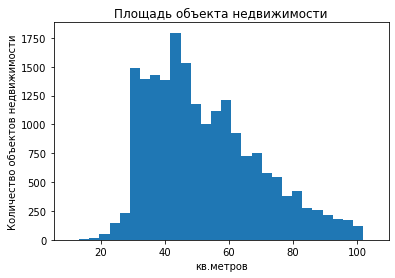

count    19528.00
mean        52.21
std         17.05
min         12.00
25%         38.90
50%         48.90
75%         62.80
max        101.60
Name: total_area, dtype: float64

In [50]:
plt.hist(data['total_area'], bins=30, range=(10,105))
plt.title('Площадь объекта недвижимости')
plt.xlabel('кв.метров')
plt.ylabel('Количество объектов недвижимости')
plt.show()
data['total_area'].describe().round(2)


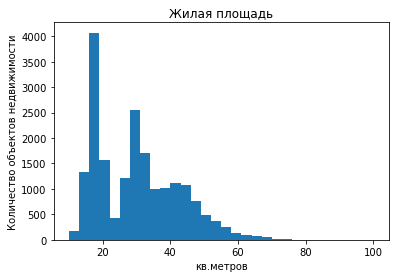

count    19528.00
mean        29.87
std         12.29
min          8.00
25%         18.00
50%         29.00
75%         38.90
max         89.10
Name: living_area, dtype: float64

In [51]:
plt.hist(data['living_area'], bins=30, range=(10,100))
plt.title('Жилая площадь')
plt.xlabel('кв.метров')
plt.ylabel('Количество объектов недвижимости')
plt.show()
data['living_area'].describe().round(2)

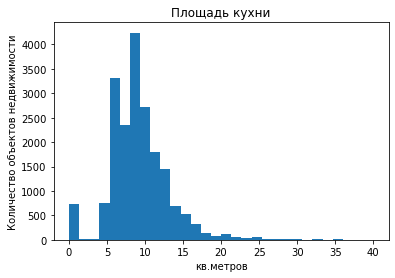

count    19528.00
mean         9.15
std          4.06
min          0.00
25%          6.70
50%          8.70
75%         11.00
max         50.00
Name: kitchen_area, dtype: float64

In [52]:
plt.hist(data['kitchen_area'], bins=30, range=(0,40))
plt.title('Площадь кухни')
plt.xlabel('кв.метров')
plt.ylabel('Количество объектов недвижимости')
plt.show()
data['kitchen_area'].describe().round(2)

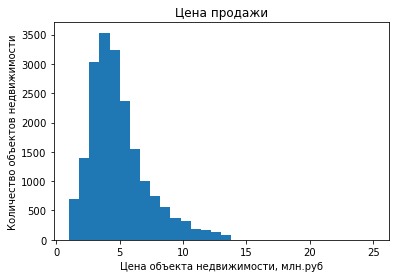

count       19528.0
mean      4855029.0
std       2287328.0
min        430000.0
25%       3320000.0
50%       4400000.0
75%       5902500.0
max      13690000.0
Name: last_price, dtype: float64

In [53]:
plt.hist(data['price_mil'], bins=30, range=(1,25))
plt.title('Цена продажи')
plt.xlabel('Цена объекта недвижимости, млн.руб')
plt.ylabel('Количество объектов недвижимости')
plt.show()
data['last_price'].describe().round()

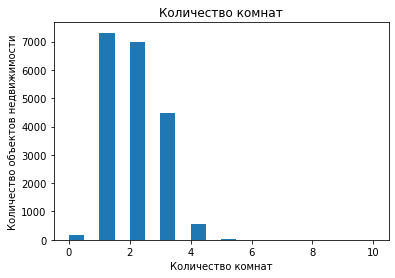

count    19528.0
mean         2.0
std          1.0
min          0.0
25%          1.0
50%          2.0
75%          3.0
max          5.0
Name: rooms, dtype: float64

In [54]:
plt.hist(data['rooms'], bins=20, range=(0,10))
plt.title('Количество комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество объектов недвижимости')
plt.show()
data['rooms'].describe().round()

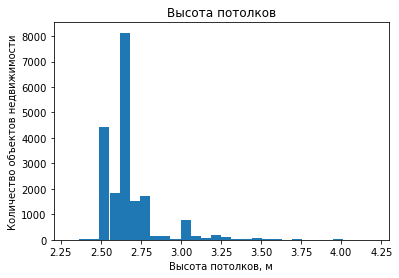

count    19528.00
mean         2.67
std          0.17
min          2.30
25%          2.60
50%          2.65
75%          2.70
max          4.20
Name: ceiling_height, dtype: float64

In [55]:
plt.hist(data['ceiling_height'], bins=30, range=(2.3,4.2))
plt.title('Высота потолков')
plt.xlabel('Высота потолков, м')
plt.ylabel('Количество объектов недвижимости')
plt.show()
data['ceiling_height'].describe().round(2)

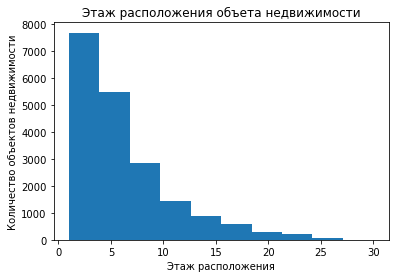

count    19528.0
mean         6.0
std          5.0
min          1.0
25%          2.0
50%          4.0
75%          8.0
max         33.0
Name: floor, dtype: float64

In [56]:
plt.hist(data['floor'], bins=10, range=(1,30))
plt.title('Этаж расположения объета недвижимости')
plt.xlabel('Этаж расположения')
plt.ylabel('Количество объектов недвижимости')
plt.show()
data['floor'].describe().round()

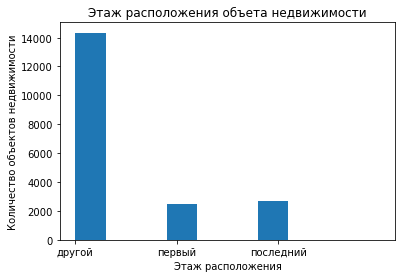

floor_type
другой       14338
последний     2682
первый        2508
Name: index, dtype: int64

In [57]:
plt.hist(data['floor_type'], bins=10, range=(0,3))
plt.title('Этаж расположения объета недвижимости')
plt.xlabel('Этаж расположения')
plt.ylabel('Количество объектов недвижимости')
plt.show()
data.groupby('floor_type')['index'].count().sort_values(ascending=False)


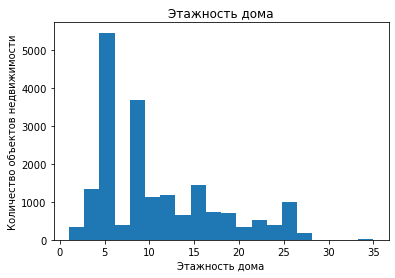

count    19528.0
mean        11.0
std          7.0
min          1.0
25%          5.0
50%          9.0
75%         16.0
max         60.0
Name: floors_total, dtype: float64

In [58]:
plt.hist(data['floors_total'], bins=20, range=(1,35))
plt.title('Этажность дома')
plt.xlabel('Этажность дома')
plt.ylabel('Количество объектов недвижимости')
plt.show()
data['floors_total'].describe().round()

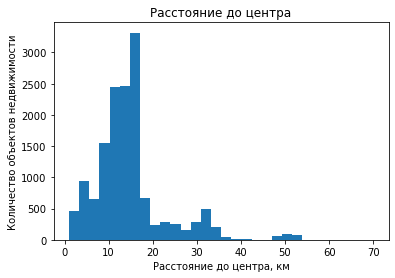

count    14780.0
mean        15.0
std          8.0
min          0.0
25%         11.0
50%         14.0
75%         17.0
max         66.0
Name: cityCenters_nearest, dtype: float64

In [59]:
plt.hist(data['cityCenters_nearest'], bins=30, range=(1,70))
plt.title('Расстояние до центра')
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Количество объектов недвижимости')
plt.show()
data['cityCenters_nearest'].describe().round()

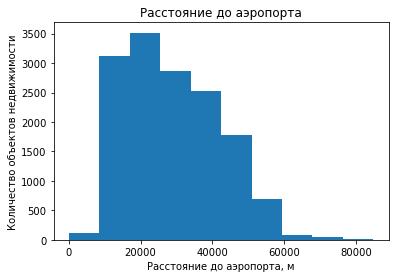

count    14765.0
mean     28885.0
std      12925.0
min          0.0
25%      18012.0
50%      27245.0
75%      37593.0
max      84869.0
Name: airports_nearest, dtype: float64

In [60]:
plt.hist(data['airports_nearest'], )
plt.title('Расстояние до аэропорта')
plt.xlabel('Расстояние до аэропорта, м')
plt.ylabel('Количество объектов недвижимости')
plt.show()
data['airports_nearest'].describe().round()

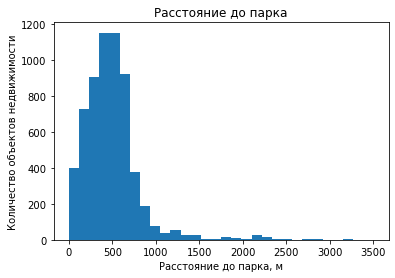

count    6147.0
mean      489.0
std       328.0
min         1.0
25%       292.0
50%       456.0
75%       613.0
max      3190.0
Name: parks_nearest, dtype: float64

In [61]:
plt.hist(data['parks_nearest'], bins=30, range=(1,3500))
plt.title('Расстояние до парка')
plt.xlabel('Расстояние до парка, м')
plt.ylabel('Количество объектов недвижимости')
plt.show()
data['parks_nearest'].describe().round()

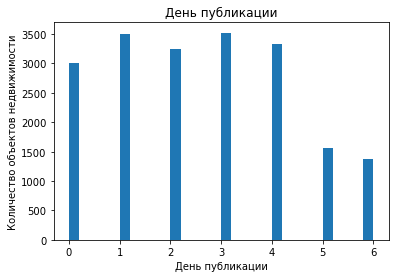

count    19528.000000
mean         2.556176
std          1.787107
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: week_day, dtype: float64

In [62]:
plt.hist(data['week_day'], bins=30, range=(0,6))
plt.title('День публикации')
plt.xlabel('День публикации')
plt.ylabel('Количество объектов недвижимости')
plt.show()
data['week_day'].describe()

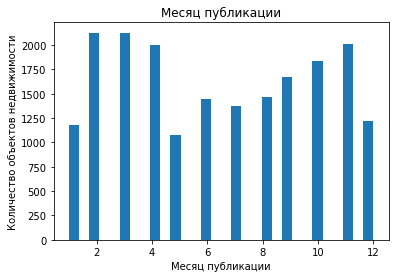

count    19528.000000
mean         6.422726
std          3.462382
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64

In [63]:
plt.hist(data['month'], bins=30, range=(1,12))
plt.title('Месяц публикации')
plt.xlabel('Месяц публикации')
plt.ylabel('Количество объектов недвижимости')
plt.show()
data['month'].describe()



**Вывод:**

**Площадь.** Разброс общей площади недвижимости от 12 до 101,6 кв.м. Средняя площадь составляет 52,21 кв.м, медиана - 48,9 кв.м.

**Жилая площадь.** Самые распространённые варианты с жилой площадью от 10 до 50 кв.м. После 60 кв.м встречаются единичные случаи. На гистограмме отображено два пика, что верятно обусловлено особенностями планировки для однокомнатных и двухкомнтаных квартир.

**Площадь кухни.** Самые распространённые кухни - от 5 до 13 метров. Больше 25 метров кухни практически не встречаются.

**Стоимость.** В основном стоимость недвижимости - порядка 4,5-5 миллионов рублей. Самые дешевые варианты начинаются от 430 тыс.рублей. Самый дорогой 13 690 тыс.рублей. Средняя стоимость 4 580 тыс.рублей, медиана 4 400 тыс.рублей.

**Количество комнат.** Наиболее встречающиеся варианты это одно- и двухкомнатные квартиры. Реже всего встречаются студии и многокомнатные квартиры, где больше 5 комнат.

**Высота потолков.** Большинство вариантов имеют высоту потолков от 2,5 до 2,7 метров. Средняя высота 2,67 метров, медиана - 2,65 метра.

**Этажность дома.** Средняя этажность - 11 этажей. Медиана - 9 этажей. Самый высокий этаж располодения - 60, либо это помещение в строящейся башне "Газпром", либо ошибка в данных, поскольку максимальная этажность жилого дома в Санкт-Петербурге и области 35 этажей (ЖК "Александр Невский"), максимальная этажность нежилого здания 41 этаж ("Lider Tower").

**Этаж расположения объекта.** Меньше всего недвижимости продатся на 1-ом этаже. Чаще всего примерно в 75 % случаев это не первый и не последний этаж.


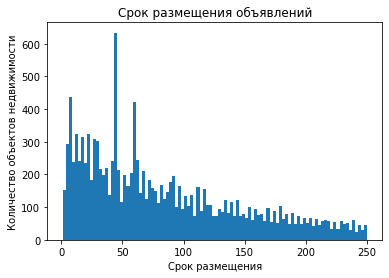

count    17094.0
mean       176.0
std        213.0
min          1.0
25%         42.0
50%         95.0
75%        225.0
max       1580.0
Name: days_exposition, dtype: float64

In [64]:
plt.hist(data['days_exposition'], bins=100, range=(1,250))
plt.title('Срок размещения объявлений')
plt.xlabel('Срок размещения')
plt.ylabel('Количество объектов недвижимости')
plt.show()
data['days_exposition'].describe().round()

**Вывод**
Медианное время продажи - 101 день, половина выставленных объектов продались в срок до 3,5 месяцев. Среднее время продажи - 185 дней. В основном квартиры продаются за срок 44 до 238 дней. Есть большое число квартир, проданных всего за несколько дней после публикации. А также есть варианты, которые продавались несколько лет.
Быстрой продажей можно назвать срок в 44 дней и меньше. Долгой продажей - 238 дней (7,5 месяцев) и дольше.

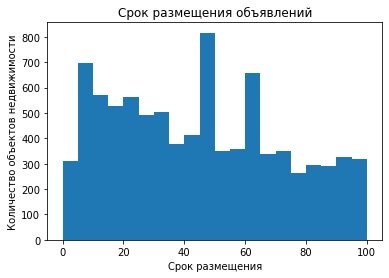

count    17094.0
mean       176.0
std        213.0
min          1.0
25%         42.0
50%         95.0
75%        225.0
max       1580.0
Name: days_exposition, dtype: float64

In [65]:
plt.hist(data['days_exposition'], bins=20, range=(0,100))
plt.title('Срок размещения объявлений')
plt.xlabel('Срок размещения')
plt.ylabel('Количество объектов недвижимости')
plt.show()
data['days_exposition'].describe().round()



**Вывод**
Медианное время продажи - 95 день, половина выставленных объектов продались в срок до 3-х месяцев. Среднее время продажи - 176 дней. В основном квартиры продаются за срок 42 до 225 дней. Есть большое число квартир, проданных всего за несколько дней после публикации. А также есть варианты, которые продавались несколько лет.
Быстрой продажей можно назвать срок в 42 дней и меньше. Долгой продажей - 225 дней (7,5 месяцев) и дольше.
    При детальном рассмотрении срока до 100 дней, наблюдаются пики на 45 и 65 день, что может говорить об автоматическом снятии объвления с продажи.


**4.2.Определение факторов, влияющих на стоимость объекта недвижимости**

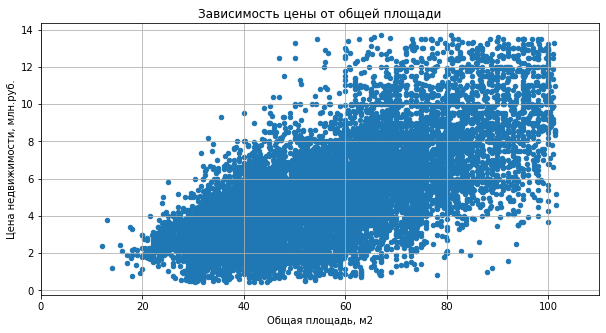

Коэффициент корреляции: 0.69


In [66]:
data.plot(x='total_area', y='price_mil', kind='scatter', xlim=(0,110), grid=True, figsize=(10,5))
plt.title('Зависимость цены от общей площади')
plt.xlabel('Общая площадь, м2')
plt.ylabel('Цена недвижимости, млн.руб.')
plt.show()
print('Коэффициент корреляции:', data['total_area'].corr(data['last_price']).round(2))

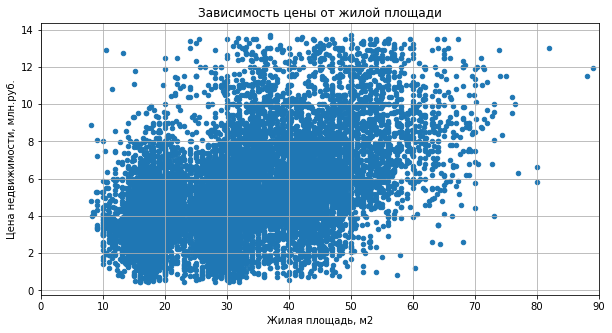

Коэффициент корреляции: 0.55


In [67]:

data.plot(x='living_area', y='price_mil', kind='scatter', xlim=(0,90), grid=True, figsize=(10,5))
plt.title('Зависимость цены от жилой площади')
plt.xlabel('Жилая площадь, м2')
plt.ylabel('Цена недвижимости, млн.руб.')
plt.show()
print('Коэффициент корреляции:', data['living_area'].corr(data['last_price']).round(2))    

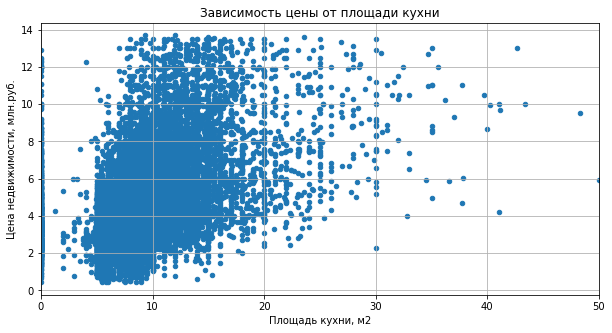

Коэффициент корреляции: 0.46


In [68]:
data.plot(x='kitchen_area', y='price_mil', kind='scatter', xlim=(0,50), grid=True, figsize=(10,5))
plt.title('Зависимость цены от площади кухни')
plt.xlabel('Площадь кухни, м2')
plt.ylabel('Цена недвижимости, млн.руб.')
plt.show()
print('Коэффициент корреляции:', data['kitchen_area'].corr(data['last_price']).round(2))

Зависимость цены от числа комнат
Коэффициент корреляции: 0.42


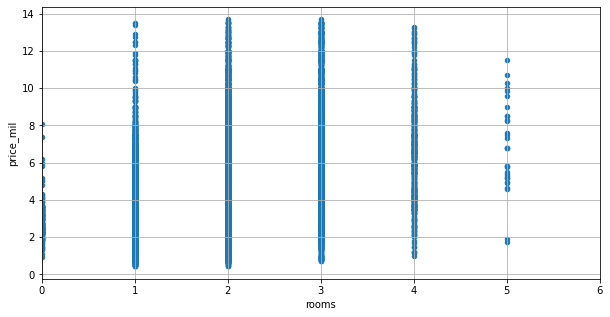

In [69]:
print('Зависимость цены от числа комнат')
data.plot(x='rooms', y='price_mil', kind='scatter', xlim=(0,6), grid=True, figsize=(10,5))
print('Коэффициент корреляции:', data['rooms'].corr(data['last_price']).round(2))

Зависимость цены от этажа объекта недвижимости


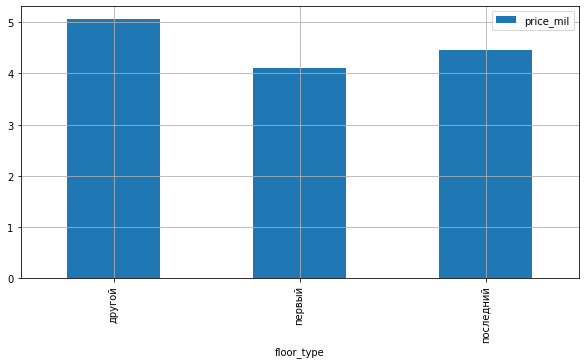

In [70]:
print('Зависимость цены от этажа объекта недвижимости')
(
    data.pivot_table(index='floor_type', values='price_mil')
    .plot(kind='bar', grid=True, figsize=(10,5))
)
plt.show()



**Вывод:**

Чем больше площадь, тем выше стоимость недвижимости. Корреляция этих параметров высокая. Число и жилая площадь комнат влияет на цену (больше комнат - больше цена), однако зависимость ниже, чем у площади. 

Первый этаж непосредственно влияет на стоимость квартиры - в среднем квартиры на 1-м этаже значительно дешевле. Наибольшая стоимость у объектов, расположенных не на 1-м и не на последнем этаже.

Зависимость цены от времени размещения объявления


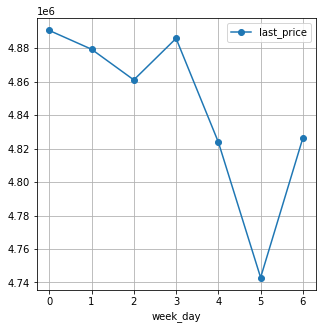

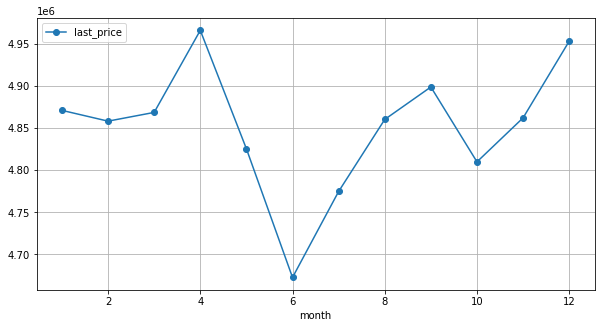

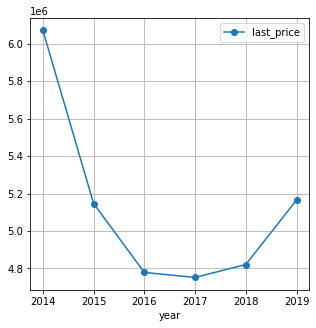

In [71]:
print('Зависимость цены от времени размещения объявления')

(
    data.pivot_table(index='week_day', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()

(
    data.pivot_table(index='month', values='last_price')
    .plot(grid=True, style='o-', figsize=(10, 5))
)
plt.show()

(
    data.pivot_table(index='year', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()

**Вывод:**
 Зависимость от дня недели, месяца и года.
**День недели:** дороже всего объекты недвижимости, опубликованные в в понедельник и среду, дешевле всего - в субботу.
**Месяц:** дороже всего объекты, объявления по которым опубликовали в апреле и декабре, дешевле всего - в июне.
**Год:** пик стоимости недвижимости наблюдается в 2014 году. Далее идет снижение цены к 2017 году и новый рост к 2019 году. Отрицательная динамика цены 2014-2017 гг вероятнее всего обуславливается экономическим кризисом 2014 года.


**4.3.Сравнение средней стоимости квадратного метра в топ-10 городов по числу размещенных объявлений**

In [72]:
city_ten = data['locality_name'].value_counts().head(10)
city_price_meter = data.query('locality_name in (@city_ten.index)').pivot_table(values='price_meter', index='locality_name')
city_price_meter = city_price_meter.astype(int)
city_price_meter.sort_values('price_meter', ascending=False)


,price_meter
locality_name,
Санкт-Петербург,106832
Пушкин,98274
Кудрово,94976
Парголово,89996
Мурино,86562
Петергоф,81576
Шушары,78638
Колпино,74930
Гатчина,67778


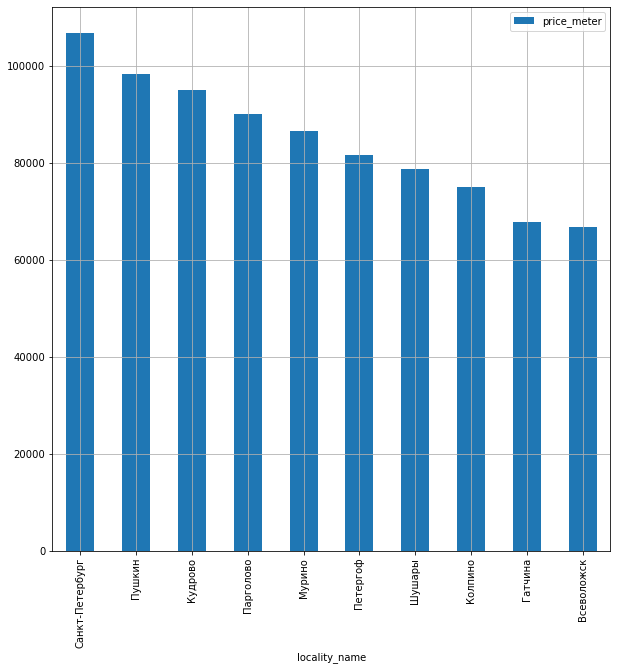

In [73]:


(
    data.query('locality_name in (@city_ten.index)').pivot_table(values='price_meter', index='locality_name')
    .sort_values('price_meter', ascending=False)
    .plot(grid=True, kind='bar', figsize=(10, 10))
)
plt.show()


**Вывод:**

Наибольшая средняя стоимость квадратного метра, как и ожидалось, в Санкт-Петербурге. Затем идёт Пушкин, что, вероятно, вызвано развитой инфраструктурой, малоэтажной застройкой и большим количеством парков. Затем идут районы непосредственно примыкающие к Санкт-Петербургу. Из топ-10 городов по числу объявлений о продаже - наименьшая стоимость наблюдается в Гатчине и во Всеволожске.

**4.5.Зависимость средней цены квадратного метра недвижимости от удаленности от центра г.Санкт_петербурга**

In [74]:
new_spb_data = data.loc[data['locality_name'] == 'Санкт-Петербург'].reset_index()#выделяем квартиры в Санкт-Петербурге                                                

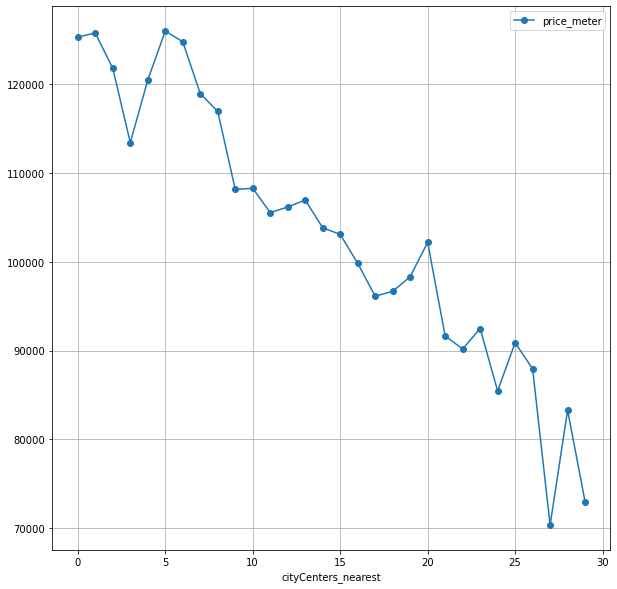

In [75]:
(
    new_spb_data.pivot_table(index='cityCenters_nearest', values='price_meter', aggfunc='mean')
    .plot(grid=True, style='o-', figsize=(10, 10))
)
plt.show()

**Вывод:**

    Цена квадратного метра с увеличением удаленности от центра г.Санкт-Петербурга уменьшается. Есть пики значений на 5 и 20 км, что может подтверждать расположение в этих зонах элитной застройки.

**5.Общий вывод:**

Мы обработали полученный архив данных - обработали пропущенные значения там, где это необходимо, заменили типы данных на необходимые для корректной работы, убрали неявные дубликаты данных. 

Посчитали и добавили в таблицу цену квадратного метра жилья, вывели из даты дни недели, месяцы и годы размещения объявлений, добавили категории по этажам квартир. 

Выявили средние показетели продаваемого объекта недвижимости: это квартира общей площадью 48-52 кв.м, жилой 10-30 кв.м, площадью кухни 9-10 кв.м, имеющая одну или две комнаты, расположенная на не на первом и не последнем этаже, стоиомтью от 4,5 до 5 млн. рублей, в среднем удалена от центра на 11 км, рядом с парком (500 метров о парка).

Определили медианное время продажи - 95 день, половина выставленных объектов продались в срок до 3 месяцев. Среднее время продажи - 182 дня. В основном квартиры продаются за срок 42 до 225 дней. 

Выяснили, что пик стоимости недвижимости в исследуемом регионе наблюдался в 2014 году. Далее идет снижение цены к 2017 году и новый рост к 2019 году. 

Отмечаем, что наибольшее влияние на стоимость недвижимости оказывают следующие факторы:
1.Чем больше площадь, тем выше стоимость недвижимости. 
2.Число и жилая площадь комнат влияет на цену (больше комнат/жилая площадь - больше цена).
3.Первый этаж непосредственно влияет на стоимость квартиры - в среднем квартиры на 1-м этаже значительно дешевле. Наибольшая стоимость у объектов, расположенных не на 1-м и не на последнем этаже.
4.Растояние до центра города. Чем меньше растояние, тем больше цена квадратного метра.